# Module 8: Multi-Particle Simulations: Lennard-Jones Fluid with ASE

Welcome to Module 8! Having explored 1D systems and enhanced sampling, we now move to simulating more realistic, multi-particle systems in 3D. Writing efficient MD code for many particles is complex, involving neighbor lists, parallelization, and robust integrators. Therefore, we will use a powerful library designed for this purpose: the **Atomic Simulation Environment (ASE)**.

In this module, we will learn the basics of ASE by setting up, running, and analyzing a simulation of a classic model system: the Lennard-Jones (LJ) fluid. This system, composed of particles interacting via the LJ potential, serves as a fundamental model for simple liquids and gases.

## Lesson 8.1: Introduction to ASE (Atomic Simulation Environment)

**What is ASE?**
ASE is a Python library for setting up, manipulating, running, visualizing, and analyzing atomistic simulations. It doesn't perform the core calculations itself (like integrating equations of motion or calculating forces for complex potentials) but acts as a powerful interface or "glue" connecting various external simulation codes (like LAMMPS, GPAW, VASP, Quantum Espresso) and internal calculators (like the Lennard-Jones calculator we'll use).

**Key Features:**
* **Atoms Object:** A central object representing a collection of atoms with positions, momenta, cell dimensions, boundary conditions, etc.
* **Calculators:** Objects attached to `Atoms` that compute energy and forces (e.g., LJ potential, EMT potential, interfaces to DFT codes or complex force fields via OpenMM/LAMMPS).
* **Dynamics/Optimization:** Modules for running MD simulations (NVE, NVT, NPT using various integrators/thermostats) or performing structure optimization.
* **Input/Output:** Reading and writing various file formats common in atomistic simulations.
* **Analysis Tools:** Built-in functions for common analysis tasks (e.g., RDF).
* **Building Tools:** Functions for creating common structures (surfaces, bulk crystals, nanotubes, etc.).

**Installation:**
If you haven't installed ASE yet, you can typically do so via pip:
```bash
pip install ase
```
Or conda:
```bash
conda install -c conda-forge ase
```

**Basic ASE Objects:**
* `ase.Atoms`: Stores the state of the system (positions, numbers, cell, pbc, calculator, momenta).
* `ase.calculators`: Contains modules for different ways to calculate energy and forces. We'll use `ase.calculators.lj.LennardJones`.

### Importing ASE modules

Let's import the necessary ASE modules along with NumPy and Matplotlib.

In [3]:
!pip install ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# ASE imports
try:
    from ase import Atoms, units
    from ase.calculators.lj import LennardJones # LJ potential calculator
    from ase.md.langevin import Langevin # Langevin dynamics integrator
    from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
    from ase.optimize import BFGS # For potential energy minimization
    from ase.io import read, write, Trajectory
    from ase.build import bulk # For creating initial bulk structure
    # For RDF calculation
    from ase.geometry.analysis import get_rdf

    print("ASE modules imported successfully.")
except ImportError as e:
    print(f"Error importing ASE modules: {e}")
    print("Please ensure ASE is installed ('pip install ase')")

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6,4)

ASE modules imported successfully.


## Lesson 8.2: Setting up the LJ System

We'll simulate Argon (Ar), a noble gas often modeled using the Lennard-Jones potential. The LJ potential is:
$$ V_{LJ}(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right] $$
For Argon, typical parameters are:
* $\sigma \approx 3.405$ Å (Angstroms)
* $\epsilon \approx 0.0103$ eV (electron Volts) or $119.8$ K $\times k_B$

ASE uses specific units internally (eV for energy, Å for length).

**Steps:**
1.  Create an initial configuration of Ar atoms (e.g., start from a face-centered cubic (fcc) lattice).
2.  Define the simulation box and apply Periodic Boundary Conditions (PBC).
3.  Set up the Lennard-Jones calculator with the appropriate parameters.
4.  Assign initial velocities corresponding to a desired temperature.

### 1. Create Initial Configuration & Apply PBC

We can use `ase.build.bulk` to create a unit cell and then repeat it to get a larger system. We choose a lattice constant `a` appropriate for the desired density. The density affects the phase (solid, liquid, gas). Let's aim for a liquid-like density.

In [6]:
# Parameters for Argon LJ potential
sigma_Ar = 3.405 # Angstrom
epsilon_Ar = 0.0103 # eV (approx 120 K * kB)

# Simulation box setup
N_side = 5 # Number of unit cells per side (N = 4 * N_side^3 atoms for fcc)
lattice_constant = 5.7 # Angstroms (chosen for liquid-like density)

# Create the bulk fcc structure and repeat it
atoms = bulk('Ar', 'fcc', a=lattice_constant, cubic=True)
atoms = atoms.repeat((N_side, N_side, N_side))
N_atoms = len(atoms)

print(f"PBC enabled: {atoms.pbc.all()}")
print(f"Number of atoms: {N_atoms}")
print(f"Simulation box dimensions:{atoms.cell}")
box_volume = atoms.get_volume()
print(f"Initial volume: {box_volume:.2f} A^3")

# Calculate initial density
mass_Ar_amu = 39.948 # amu
mass_Ar_ase = mass_Ar_amu * units._amu # ASE mass unit
number_density = N_atoms / box_volume
print(f"Number density: {number_density:.4f} atoms/A^3")

PBC enabled: True
Number of atoms: 500
Simulation box dimensions:Cell([28.5, 28.5, 28.5])
Initial volume: 23149.12 A^3
Number density: 0.0216 atoms/A^3


### 2. Set up the Lennard-Jones Calculator

Attach the `LennardJones` calculator to the `Atoms` object. ASE's LJ calculator uses $\sigma$ and $\epsilon$.

In [7]:
# Set the calculator
atoms.calc = LennardJones(sigma=sigma_Ar, epsilon=epsilon_Ar, rc=sigma_Ar * 3.0) # rc is cutoff radius

# Check initial energy and forces (should be non-zero due to initial lattice)
initial_potential_energy = atoms.get_potential_energy()
initial_forces = atoms.get_forces()
print(f"Initial Potential Energy: {initial_potential_energy:.4f} eV")
# print(f"Max initial force component: {np.max(np.abs(initial_forces)):.4f} eV/A")

# Optional: Minimize energy to get a more stable starting point (removes initial forces)
print("Minimizing initial structure...")
optimizer = BFGS(atoms, logfile='minimization.log')
optimizer.run(fmax=0.01) # Run until max force component is below 0.01 eV/A
minimized_potential_energy = atoms.get_potential_energy()
print(f"Minimized Potential Energy: {minimized_potential_energy:.4f} eV")
write('minimized_structure.xyz', atoms)

Initial Potential Energy: -34.9023 eV
Minimizing initial structure...
Minimized Potential Energy: -34.9023 eV


### 3. Assign Initial Velocities

Use `MaxwellBoltzmannDistribution` to assign velocities corresponding to a target temperature. It's also good practice to remove any center-of-mass motion.

In [8]:
# Target temperature for initialization (and simulation)
target_temperature_K = 90.0 # Kelvin (liquid Argon range)
target_temperature_eV = target_temperature_K * units.kB # Convert K to eV using ase.units

# Set initial velocities
MaxwellBoltzmannDistribution(atoms, temperature_K=target_temperature_K)
# Remove center-of-mass motion (avoids box drifting)
Stationary(atoms)
# Remove rotation (optional, less critical for fluids)
# ZeroRotation(atoms)

# Check initial kinetic energy and temperature
initial_kinetic_energy = atoms.get_kinetic_energy()
initial_temperature = initial_kinetic_energy / (1.5 * units.kB * len(atoms)) # 3N DOF -> 1.5 N kB T
print(f"Initial Target Temperature: {target_temperature_K:.1f} K ({target_temperature_eV:.4f} eV)")
print(f"Initial Kinetic Energy: {initial_kinetic_energy:.4f} eV")
print(f"Initial Temperature (from KE): {initial_temperature:.1f} K")

Initial Target Temperature: 90.0 K (0.0078 eV)
Initial Kinetic Energy: 5.6850 eV
Initial Temperature (from KE): 88.0 K


## Lesson 8.3: Running NVT Simulations with ASE

Now we set up the Molecular Dynamics simulation run itself. We'll use the **Langevin thermostat** to maintain the target temperature (NVT ensemble).

**Steps:**
1.  Choose simulation parameters (time step, total steps).
2.  Create a `Langevin` dynamics object, linking the `Atoms` object, time step, temperature, and friction coefficient.
3.  Define how to log data or save the trajectory during the run.
4.  Run the simulation using the `dyn.run()` method.

In [9]:
# Simulation parameters
time_step_fs = 5.0 # femtoseconds
time_step = time_step_fs * units.fs
# Define picoseconds numerically based on femtoseconds
# This 'ps' variable holds the value of 1 picosecond in ASE's internal time units
ps = 1000.0 * units.fs
total_simulation_time_ps = 10.0 # picoseconds
total_simulation_time = total_simulation_time_ps * ps # Total time in ASE units
n_steps = int(total_simulation_time / time_step)
log_interval = 200 # Print status less often
traj_interval = 1000 # Save trajectory frame less often
traj_filename = 'lj_argon_nvt.traj'

print(f"Simulation time step: {time_step_fs:.1f} fs ({time_step / units.fs:.3f} ASE time units)")
print(f"1 Picosecond equals: {ps:.3f} ASE time units")
print(f"Total simulation time: {total_simulation_time_ps:.1f} ps ({total_simulation_time:.3f} ASE time units)")
print(f"Number of steps: {n_steps}")

# Set up Langevin dynamics
friction_coeff = 0.01 / units.fs
dyn = Langevin(atoms, timestep=time_step, temperature_K=target_temperature_K, friction=friction_coeff)

# Function to print progress
def print_status(a=atoms):
    """Function called by the dynamics to print status."""
    step = dyn.get_number_of_steps()
    if step % log_interval == 0: # Print only at log_interval
        epot = a.get_potential_energy() / len(a)
        ekin = a.get_kinetic_energy() / len(a)
        # Ensure temperature calculation is safe (avoid division by zero if ekin is zero)
        temp = ekin / (1.5 * units.kB) if ekin > 1e-9 else 0.0
        # Calculate current time in picoseconds using the 'ps' variable defined earlier
        current_time_ps = (step * time_step) / ps
        print(f'Step: {step:6d}, Time: {current_time_ps:6.2f} ps, '
              f'Epot/N: {epot:.4f} eV, Ekin/N: {ekin:.4f} eV, Temp: {temp:.1f} K')

# Attach status printing
# The dyn object will call print_status() at each step internally.
# The check for log_interval is handled inside print_status.
dyn.attach(print_status, interval=1) # Attach to be called every step

# Set up trajectory saving
# Check if file exists, delete if you want to overwrite cleanly
if os.path.exists(traj_filename):
    try:
        os.remove(traj_filename)
        print(f"Removed existing trajectory file: {traj_filename}")
    except OSError as e:
        print(f"Error removing existing trajectory file {traj_filename}: {e}")
        # Decide if you want to exit or continue
        # exit() or pass

# Use a try-finally block to ensure the trajectory file is opened and closed properly
trajectory = None # Initialize trajectory to None
try:
    trajectory = Trajectory(traj_filename, 'w', atoms)
    # Attach trajectory writing with the specified interval
    dyn.attach(trajectory.write, interval=traj_interval)

    print("-" * 60)
    print(f"Starting NVT simulation for {n_steps} steps...")
    print(f"Target Temperature: {target_temperature_K:.1f} K")
    print(f"Trajectory will be saved to: {traj_filename} every {traj_interval} steps.")
    print(f"Status will be printed every {log_interval} steps.")
    print("-" * 60)


    # Run the dynamics!
    sim_start_time = time.time()
    dyn.run(n_steps)
    sim_end_time = time.time()
    print("-" * 60)
    print(f"NVT simulation finished successfully in {sim_end_time - sim_start_time:.2f} seconds.")
    print("-" * 60)

except Exception as e:
    sim_end_time = time.time()
    print("-" * 60)
    print(f"Error during simulation run after {sim_end_time - sim_start_time:.2f} seconds: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback
    print("-" * 60)

finally:
    # Important: Always close the trajectory file if it was opened
    if trajectory is not None:
        try:
            trajectory.close()
            print("Trajectory file closed.")
        except Exception as e:
            print(f"Error closing trajectory file: {e}")


Simulation time step: 5.0 fs (5.000 ASE time units)
1 Picosecond equals: 98.227 ASE time units
Total simulation time: 10.0 ps (982.269 ASE time units)
Number of steps: 2000
------------------------------------------------------------
Starting NVT simulation for 2000 steps...
Target Temperature: 90.0 K
Trajectory will be saved to: lj_argon_nvt.traj every 1000 steps.
Status will be printed every 200 steps.
------------------------------------------------------------
Step:      0, Time:   0.00 ps, Epot/N: -0.0698 eV, Ekin/N: 0.0114 eV, Temp: 88.0 K
Step:    200, Time:   1.00 ps, Epot/N: -0.0620 eV, Ekin/N: 0.0119 eV, Temp: 91.7 K
Step:    400, Time:   2.00 ps, Epot/N: -0.0612 eV, Ekin/N: 0.0120 eV, Temp: 93.2 K
Step:    600, Time:   3.00 ps, Epot/N: -0.0606 eV, Ekin/N: 0.0124 eV, Temp: 96.1 K
Step:    800, Time:   4.00 ps, Epot/N: -0.0603 eV, Ekin/N: 0.0120 eV, Temp: 92.7 K
Step:   1000, Time:   5.00 ps, Epot/N: -0.0602 eV, Ekin/N: 0.0114 eV, Temp: 88.4 K
Step:   1200, Time:   6.00 ps, Ep

**Running at Different Temperatures:**
To observe different phases (solid, liquid, gas), you would typically run similar simulations but change the `target_temperature_K` (and potentially the initial density/lattice constant).
* **Solid:** Lower temperature (e.g., 20 K) and potentially slightly higher density.
* **Gas:** Higher temperature (e.g., 300 K) and lower density (larger `lattice_constant` or fewer atoms in the box).
You would then analyze properties like the RDF (see next section) to characterize the phase.

## Lesson 8.4: Analysis of LJ System Properties

After the simulation, we analyze the results stored in the log files and trajectory.

**Thermodynamic Properties:**
Temperature, potential energy, kinetic energy, and total energy were printed during the run. We can also extract them from the saved trajectory or log files for plotting time series or calculating averages. Pressure can also be calculated (related to forces and kinetic energy via the virial theorem), especially important for NPT simulations.

**Structural Properties:**
* **Density:** Calculated from the number of atoms, mass, and box volume. Should remain constant in NVT.
* **Radial Distribution Function (RDF), g(r):** This is a crucial function describing the structure of fluids and solids. $g(r)$ measures the probability of finding another particle at a distance $r$ from a reference particle, relative to the probability expected for a uniform random distribution (ideal gas).
    * **Gases:** $g(r)$ quickly approaches 1 for $r > \sigma$, indicating little structure.
    * **Liquids:** Show a strong peak around $r \approx \sigma$ (first solvation shell), followed by damped oscillations approaching 1, indicating short-range order.
    * **Solids:** Show sharp, distinct peaks corresponding to crystallographic neighbor distances, indicating long-range order.

**Calculating RDF using ASE:**
ASE provides tools to calculate the RDF from an `Atoms` object or a trajectory.

### Calculating the RDF

Let's calculate the RDF for the *final* state of our simulation. For a proper analysis, one would typically average the RDF over several frames from the production phase of the trajectory.

Calculating RDF up to rmax = 14.15 A with 100 bins...


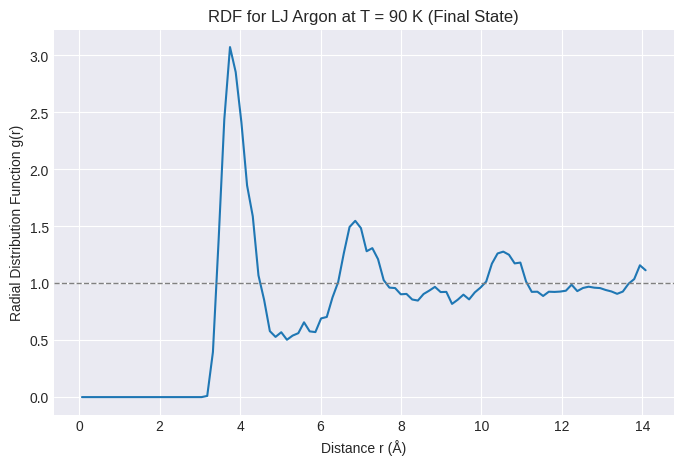

Interpretation:
- Expect a strong peak near sigma (~3.4 A) representing the first neighbor shell.
- Expect subsequent peaks (oscillations) indicating short-range liquid order.
- Expect g(r) to approach 1 at larger distances.


In [10]:
# --- RDF Calculation ---
# We need the final Atoms object from the simulation
# The 'atoms' object should hold the final state after dyn.run()

# Parameters for RDF calculation
rmax = min(atoms.cell.lengths()) / 2.0 - 0.1 # Maximum distance (up to half the box size)
nbins = 100 # Number of bins for the RDF histogram

print(f"Calculating RDF up to rmax = {rmax:.2f} A with {nbins} bins...")

try:
    # get_rdf returns rdf values and corresponding bin centers (r)
    rdf, r = get_rdf(atoms, rmax, nbins) # Use the final 'atoms' state

    # Plot the RDF
    plt.figure(figsize=(8, 5))
    plt.plot(r, rdf)
    plt.xlabel("Distance r (Å)")
    plt.ylabel("Radial Distribution Function g(r)")
    plt.title(f"RDF for LJ Argon at T = {target_temperature_K:.0f} K (Final State)")
    plt.axhline(1.0, color='grey', linestyle='--', linewidth=1) # Reference line for ideal gas
    plt.grid(True)
    plt.show()

    # Interpretation based on expected liquid state at 90K
    print("Interpretation:")
    print("- Expect a strong peak near sigma (~3.4 A) representing the first neighbor shell.")
    print("- Expect subsequent peaks (oscillations) indicating short-range liquid order.")
    print("- Expect g(r) to approach 1 at larger distances.")

except Exception as e:
    print(f"Error calculating RDF: {e}")
    print("This might happen if the simulation state is unusual or ASE version differs.")

### Visualizing Trajectories

The trajectory was saved to `lj_argon_nvt.traj`. This file can be opened with external visualization software that understands ASE trajectories, such as:
* **Ovito:** ([https://www.ovito.org/](https://www.ovito.org/)) Powerful, free (for non-commercial use) scientific visualization and analysis software. Recommended.
* **VMD:** ([https://www.ks.uiuc.edu/Research/vmd/](https://www.ks.uiuc.edu/Research/vmd/)) Widely used molecular visualization program, particularly in biophysics. Free.
* **ASE GUI:** ASE has its own simple GUI (`ase gui lj_argon_nvt.traj` from the terminal), but it's less feature-rich than Ovito or VMD.

Visualizing the trajectory helps understand the dynamics, check for equilibration, and observe phase behavior (e.g., melting, evaporation).

---
End of Module 7. We have taken a significant step from 1D models to 3D multi-particle simulations using the Atomic Simulation Environment (ASE):

* Introduced **ASE** as a powerful Python interface for atomistic simulations.
* Learned to set up a **Lennard-Jones fluid** system (Argon) using `ase.build`, applying PBC, and setting the `LennardJones` calculator.
* Initialized particle velocities using `MaxwellBoltzmannDistribution`.
* Ran an **NVT simulation** using the `Langevin` dynamics module in ASE.
* Discussed basic analysis, focusing on calculating and interpreting the **Radial Distribution Function (RDF)** using ASE tools.
* Mentioned tools for **visualizing** the simulation trajectory.

This module provides a practical starting point for using standard simulation tools to study more complex systems. In the next module, we'll apply these ASE concepts to simulate a box of water molecules, introducing molecular force fields.